In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [3]:
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [7]:
######################

In [8]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            #if (index + context >= 0 and context != 0 and index + context < len(index_words)):
            #    yield center, index_words[index + context]
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                #r = random.randint(1, 100)
             #   if (center < 4700 and target < 4700):
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: min(index + context + 1, len(index_words))]:
                #r = random.randint(1, 100)
                #if (center < 4700 and target < 4700):
                 yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1])
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = list(set(flat_codones))
    cnt_cod = dict()
    for cod in flat_codones:
        if (cod not in cnt_cod):
            cnt_cod[cod] = 0
        cnt_cod[cod] += 1
        
    unique_codones.sort(key=lambda x: -cnt_cod[x])
    #unique_codones = unique_codones[7:] + unique_codones[:7]
    for i in range(len(unique_codones)):
        print(i, unique_codones[i], cnt_cod[unique_codones[i]])
    
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

#def process_data(all_codones, batch_size, skip_window):
#    flat_codones = flatten(all_codones)
#    unique_codones = set(flat_codones)
#    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
#    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
#    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
#    batch_gen = get_batch(single_gen, batch_size=batch_size)
#    return batch_gen, dictionary

In [9]:
#random.shuffle(all_codones)
dictionary = make_dictionary(all_codones)

BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)
#batch_gen, dictionary = process_data(all_codones, BATCH_SIZE, SKIP_WINDOW)

0 AAA 152576
1 LLL 131965
2 ALA 127540
3 LAA 126274
4 AAL 124613
5 ALL 122122
6 LLA 121390
7 LAL 108417
8 EAL 98615
9 LLS 98067
10 LLE 95723
11 LLG 95716
12 SLL 95693
13 LGL 94716
14 SSS 92776
15 AAG 91347
16 VAA 91257
17 ELL 91019
18 LSL 89475
19 AGL 89407
20 LAE 89242
21 VLA 88813
22 GLL 88508
23 EEE 87829
24 VLL 87050
25 EEL 86965
26 GGG 84956
27 AVA 84760
28 LAG 84334
29 ALG 83864
30 EAA 83151
31 LLD 81649
32 LEE 81619
33 AVL 81507
34 AAV 81312
35 RLL 80885
36 LVA 80392
37 LLV 80173
38 ELA 79662
39 TLL 78862
40 LLR 78759
41 ALV 78550
42 EKL 78499
43 SAL 77429
44 LLK 77398
45 LEK 77260
46 AGA 77257
47 AEL 77170
48 ALE 77004
49 GLA 76616
50 LVL 76574
51 LEA 76381
52 ALR 76343
53 SSL 76177
54 LGA 76109
55 KLL 75608
56 AEA 75551
57 LLT 75045
58 ALS 74148
59 DLL 73954
60 LAR 73911
61 LAS 73787
62 AAE 73448
63 VAL 73072
64 LAV 72826
65 LKE 72774
66 AAR 72762
67 LSA 72551
68 LAK 72501
69 VVA 72016
70 LSG 71943
71 ASL 71785
72 LSS 71736
73 AIA 71381
74 RAL 71215
75 SLA 71093
76 GAL 71017
7

1242 VVP 31398
1243 NGL 31393
1244 TRA 31385
1245 DGI 31361
1246 DFL 31345
1247 PLR 31322
1248 KVG 31290
1249 RIV 31289
1250 EIG 31287
1251 DSG 31271
1252 GRT 31264
1253 RRK 31255
1254 PLD 31251
1255 KGA 31227
1256 LEP 31210
1257 MAA 31207
1258 PLE 31189
1259 DDI 31187
1260 KVS 31182
1261 ISR 31172
1262 PGE 31157
1263 VAQ 31149
1264 IFL 31142
1265 EGS 31127
1266 LDN 31126
1267 SDI 31114
1268 ETE 31096
1269 SAD 31083
1270 TVK 31074
1271 QEA 31071
1272 IEN 31066
1273 SIT 31054
1274 DKA 31053
1275 DSE 31037
1276 EDD 31000
1277 LNV 31000
1278 NLG 30976
1279 DKI 30972
1280 LQD 30944
1281 FLR 30938
1282 IKD 30934
1283 EEF 30925
1284 TIT 30914
1285 IKS 30903
1286 SED 30885
1287 AFS 30873
1288 ITE 30849
1289 ISD 30841
1290 YGL 30818
1291 IGD 30812
1292 SKI 30801
1293 ITD 30781
1294 RDG 30770
1295 FDL 30747
1296 ART 30719
1297 DRV 30710
1298 ADD 30697
1299 TTG 30677
1300 TVR 30650
1301 VVN 30622
1302 GTI 30609
1303 APS 30608
1304 LPR 30608
1305 DPE 30592
1306 TKE 30580
1307 EKD 30570
1308 TSV 3

1851 LFK 24932
1852 NGS 24931
1853 QRA 24929
1854 RQR 24923
1855 GSF 24921
1856 AIF 24902
1857 TRV 24893
1858 SIF 24890
1859 EAP 24882
1860 NIS 24860
1861 VNE 24854
1862 FSK 24850
1863 RKS 24849
1864 FVE 24836
1865 DTG 24834
1866 PER 24812
1867 DVG 24807
1868 NIA 24774
1869 PGD 24773
1870 QRV 24773
1871 GPS 24761
1872 PKL 24750
1873 GNI 24729
1874 RSE 24727
1875 TED 24719
1876 ARF 24705
1877 RIK 24704
1878 IPS 24698
1879 HLA 24698
1880 PRG 24684
1881 TSR 24675
1882 TKV 24659
1883 ETS 24651
1884 TRS 24646
1885 ALH 24622
1886 SAQ 24617
1887 NVI 24616
1888 EVF 24604
1889 KTE 24601
1890 GQA 24575
1891 LFN 24566
1892 ERD 24563
1893 DRE 24558
1894 SFA 24558
1895 KSR 24545
1896 RFA 24545
1897 GLY 24542
1898 IPT 24530
1899 YDL 24511
1900 AFE 24480
1901 VSQ 24480
1902 FGE 24471
1903 FGI 24463
1904 YLR 24456
1905 IVP 24454
1906 PTV 24454
1907 LNQ 24447
1908 IKI 24433
1909 IRV 24432
1910 LAM 24426
1911 LQP 24409
1912 NPE 24407
1913 FLP 24393
1914 PSI 24365
1915 LYE 24343
1916 ADP 24330
1917 IGF 2

2463 IVF 20372
2464 KDF 20367
2465 KGF 20360
2466 NVD 20354
2467 HLE 20345
2468 VQS 20342
2469 EDT 20336
2470 SRQ 20320
2471 FIT 20319
2472 TVF 20310
2473 RGF 20297
2474 MAV 20285
2475 PRV 20285
2476 PEQ 20269
2477 SGY 20254
2478 LEH 20235
2479 TLY 20219
2480 MAS 20218
2481 SNE 20194
2482 RNG 20189
2483 DRG 20177
2484 GEQ 20173
2485 TDP 20164
2486 NSK 20162
2487 SYS 20156
2488 FFS 20155
2489 QII 20142
2490 YLI 20137
2491 IIF 20132
2492 EPS 20130
2493 QSI 20127
2494 GFK 20126
2495 EGN 20109
2496 VTQ 20099
2497 AAH 20095
2498 MLK 20086
2499 AMV 20083
2500 LTY 20083
2501 DKT 20080
2502 TFV 20075
2503 PVK 20050
2504 VRP 20048
2505 GVY 20046
2506 SSY 20043
2507 ETF 20041
2508 TGF 20039
2509 PIT 20039
2510 YVA 20037
2511 LNF 20034
2512 QDV 20021
2513 YVS 20017
2514 GLH 20010
2515 MKK 20008
2516 SVQ 20003
2517 FIK 19994
2518 RKD 19953
2519 ATF 19937
2520 AYV 19935
2521 HLS 19934
2522 VML 19934
2523 PIE 19928
2524 IQK 19923
2525 REF 19918
2526 TDK 19917
2527 KQR 19902
2528 IKP 19875
2529 QGS 1

3083 IAM 16896
3084 KNT 16886
3085 TKP 16879
3086 HIL 16875
3087 NDS 16875
3088 LHP 16866
3089 GYR 16863
3090 SIY 16862
3091 IQG 16858
3092 TNE 16854
3093 EDN 16827
3094 YNL 16827
3095 KVY 16816
3096 IYS 16811
3097 KQS 16810
3098 FSN 16810
3099 NPN 16801
3100 LNY 16798
3101 AEH 16797
3102 SKF 16793
3103 YIE 16791
3104 KQQ 16778
3105 YVP 16777
3106 VNN 16771
3107 IQQ 16767
3108 YDV 16749
3109 QGD 16738
3110 HGA 16736
3111 GTN 16735
3112 HLT 16730
3113 DTF 16726
3114 YRG 16722
3115 ISY 16719
3116 GRQ 16716
3117 PTR 16714
3118 SFN 16707
3119 LIH 16706
3120 VQD 16699
3121 RAY 16692
3122 EVY 16685
3123 DEP 16681
3124 SQQ 16679
3125 MSG 16676
3126 MSS 16668
3127 DFK 16658
3128 MIL 16656
3129 NTG 16647
3130 EDY 16645
3131 NAP 16640
3132 FFV 16639
3133 QSR 16634
3134 FLY 16624
3135 VIY 16623
3136 ENF 16623
3137 ADQ 16619
3138 GIQ 16614
3139 VAH 16607
3140 AMR 16605
3141 YEV 16595
3142 QQG 16594
3143 RPI 16585
3144 VQT 16581
3145 VPQ 16576
3146 HPE 16566
3147 PDP 16565
3148 VFN 16564
3149 FTK 1

3719 SYT 13799
3720 NFT 13795
3721 VHV 13771
3722 YSP 13761
3723 FFE 13756
3724 VPN 13749
3725 TYA 13747
3726 EYR 13738
3727 GNN 13737
3728 DMA 13736
3729 KPF 13711
3730 LCA 13710
3731 SHA 13702
3732 QTR 13702
3733 PFD 13683
3734 ADM 13676
3735 YFV 13670
3736 GPN 13664
3737 EGM 13663
3738 PVY 13662
3739 HPD 13661
3740 EQN 13646
3741 AMD 13644
3742 VGH 13640
3743 TKQ 13638
3744 NHL 13631
3745 NDN 13629
3746 YVI 13616
3747 IVH 13611
3748 QFA 13601
3749 QTK 13597
3750 IQI 13592
3751 YRI 13591
3752 EEH 13581
3753 IGH 13577
3754 YEI 13575
3755 ISH 13574
3756 GRM 13563
3757 YIV 13554
3758 QEN 13550
3759 VKY 13548
3760 WLG 13544
3761 IEY 13540
3762 TKF 13529
3763 TDY 13524
3764 STY 13523
3765 NFK 13521
3766 HRA 13520
3767 DRQ 13517
3768 MIG 13513
3769 SNQ 13491
3770 KFT 13486
3771 FRN 13485
3772 MEV 13480
3773 SYD 13477
3774 QTT 13477
3775 VSH 13476
3776 YDS 13465
3777 HGS 13463
3778 VFQ 13462
3779 YDK 13460
3780 DFN 13454
3781 INF 13447
3782 DQS 13445
3783 RHA 13436
3784 PQQ 13433
3785 GIH 1

4347 PKF 11260
4348 DDQ 11259
4349 FFF 11255
4350 SYP 11254
4351 RFN 11251
4352 RMK 11249
4353 YDP 11247
4354 NYF 11243
4355 RPF 11231
4356 AMQ 11229
4357 HQA 11219
4358 ALW 11218
4359 THS 11215
4360 RKM 11214
4361 QTD 11213
4362 CSA 11209
4363 FDQ 11203
4364 WLR 11203
4365 PAH 11193
4366 YQQ 11186
4367 GTH 11184
4368 SHR 11183
4369 RFY 11177
4370 RHI 11174
4371 KMG 11168
4372 HIS 11157
4373 PND 11151
4374 NNF 11145
4375 FFP 11144
4376 IMD 11136
4377 YFT 11130
4378 MKV 11130
4379 CVL 11130
4380 YDF 11120
4381 DAH 11110
4382 PMA 11109
4383 NPP 11106
4384 VMR 11105
4385 HSE 11102
4386 CLV 11101
4387 QKF 11098
4388 WLV 11088
4389 RYK 11074
4390 RSH 11064
4391 DQT 11062
4392 RNY 11061
4393 IFQ 11060
4394 QDT 11060
4395 GCS 11059
4396 ISM 11058
4397 GGW 11048
4398 YNP 11048
4399 PYT 11045
4400 KYN 11043
4401 GMR 11040
4402 FPT 11034
4403 PQK 11027
4404 MPA 11021
4405 VHT 11020
4406 VVC 11019
4407 HTS 11019
4408 VIM 11015
4409 EHP 11015
4410 ACV 11012
4411 TYR 11011
4412 HGF 11010
4413 FYR 1

5287 ETH 7804
5288 RCG 7801
5289 VCR 7801
5290 ACR 7800
5291 ICA 7795
5292 MMA 7790
5293 VCE 7789
5294 GWD 7787
5295 LCN 7782
5296 HRP 7781
5297 KHE 7775
5298 QHV 7775
5299 GPC 7766
5300 YPP 7765
5301 VHQ 7762
5302 FHE 7759
5303 NSH 7756
5304 RMQ 7754
5305 QYQ 7754
5306 PHT 7745
5307 PMS 7742
5308 TPM 7742
5309 MQG 7737
5310 SGW 7736
5311 HKD 7735
5312 VCT 7733
5313 NYP 7726
5314 NAH 7722
5315 HQG 7719
5316 CEA 7718
5317 NKM 7711
5318 SMF 7710
5319 HPF 7708
5320 NFY 7707
5321 FVM 7706
5322 FCG 7703
5323 EIC 7698
5324 KAC 7695
5325 CAI 7694
5326 ECS 7690
5327 HPQ 7687
5328 YDQ 7686
5329 IHN 7679
5330 QHP 7665
5331 QLC 7663
5332 QRM 7660
5333 KDH 7654
5334 EVC 7654
5335 NHI 7651
5336 YML 7642
5337 EQH 7633
5338 HFR 7629
5339 YYN 7625
5340 CSR 7617
5341 CGP 7610
5342 QMI 7609
5343 YYE 7609
5344 WIL 7608
5345 WRL 7607
5346 SHY 7607
5347 FPY 7602
5348 WAV 7601
5349 NHA 7601
5350 GHN 7593
5351 QQY 7591
5352 CIS 7590
5353 PLC 7589
5354 CKE 7588
5355 FVH 7585
5356 VAW 7583
5357 WLF 7575
5358 G

5951 DFM 6051
5952 THQ 6048
5953 NRM 6048
5954 TCI 6046
5955 VDW 6046
5956 QYN 6044
5957 TNH 6041
5958 DMQ 6041
5959 GEC 6040
5960 RCS 6035
5961 VWI 6033
5962 SKC 6031
5963 FFH 6027
5964 YYP 6027
5965 AWQ 6026
5966 SVW 6025
5967 PFM 6025
5968 VCP 6025
5969 CID 6024
5970 PSW 6022
5971 RGC 6016
5972 SYM 6013
5973 QAC 6012
5974 HDT 6011
5975 NDM 6011
5976 CSF 6010
5977 KDC 6008
5978 ACF 6003
5979 ETW 6002
5980 RSW 6001
5981 EWK 5997
5982 DWA 5993
5983 HVY 5992
5984 GWI 5989
5985 LIW 5988
5986 MFP 5983
5987 HHI 5982
5988 PCA 5981
5989 DYH 5980
5990 HQE 5977
5991 FHF 5975
5992 CAK 5973
5993 KIC 5972
5994 QMP 5972
5995 MFR 5962
5996 WSK 5961
5997 SCK 5960
5998 KCK 5959
5999 CPT 5952
6000 MYS 5949
6001 AKC 5946
6002 TWE 5940
6003 TWV 5931
6004 IEC 5931
6005 CED 5930
6006 WQE 5928
6007 DWD 5927
6008 CYL 5926
6009 MQD 5926
6010 TTC 5924
6011 RMF 5923
6012 EWV 5921
6013 LQC 5920
6014 WKS 5919
6015 PHQ 5918
6016 YAH 5917
6017 CIE 5916
6018 ISW 5915
6019 HHA 5914
6020 RMM 5914
6021 PHF 5913
6022 R

6569 HEY 4702
6570 WTS 4700
6571 NCV 4699
6572 NCP 4699
6573 PMN 4696
6574 YTM 4693
6575 VWF 4692
6576 EWD 4691
6577 CLY 4683
6578 SQC 4682
6579 CYV 4669
6580 TDC 4668
6581 YHP 4664
6582 CEQ 4659
6583 CIP 4658
6584 MFF 4657
6585 RWS 4650
6586 YHQ 4649
6587 GQW 4648
6588 FHY 4648
6589 WST 4644
6590 CQE 4642
6591 NGW 4632
6592 RCD 4631
6593 QCS 4630
6594 FQH 4627
6595 WNP 4627
6596 YWV 4626
6597 AFW 4625
6598 MMT 4622
6599 FAC 4621
6600 AHM 4616
6601 IMM 4616
6602 TDW 4615
6603 RKW 4614
6604 VYC 4609
6605 NFM 4609
6606 DPC 4607
6607 FCR 4607
6608 DFC 4604
6609 QGC 4603
6610 DCF 4602
6611 NAC 4601
6612 RNC 4599
6613 ANC 4593
6614 IMY 4592
6615 PWA 4590
6616 NIC 4579
6617 WDI 4578
6618 SFW 4575
6619 WNG 4575
6620 MTM 4572
6621 MYN 4569
6622 WQS 4566
6623 HYQ 4566
6624 YMI 4565
6625 HQF 4564
6626 IWK 4564
6627 WGD 4563
6628 WAF 4561
6629 HAM 4554
6630 CNI 4553
6631 YHF 4553
6632 CVY 4550
6633 LYW 4545
6634 HHQ 4541
6635 FWS 4540
6636 SYC 4540
6637 WID 4537
6638 HHE 4537
6639 KNW 4532
6640 P

7205 FRW 3195
7206 MQH 3195
7207 WVF 3192
7208 NWF 3190
7209 HAC 3190
7210 KYW 3187
7211 YWK 3180
7212 ACC 3178
7213 WKF 3172
7214 CFF 3171
7215 CHV 3165
7216 NCF 3163
7217 HYH 3160
7218 HCR 3157
7219 KCQ 3148
7220 VMC 3146
7221 YPM 3145
7222 NPW 3145
7223 MNH 3143
7224 CPF 3136
7225 IWF 3135
7226 GMC 3114
7227 IHC 3113
7228 AHW 3109
7229 QNC 3109
7230 FEW 3109
7231 PCF 3097
7232 CAH 3096
7233 NKC 3090
7234 QCD 3088
7235 WYS 3087
7236 HVC 3085
7237 FWT 3083
7238 CDQ 3081
7239 MHK 3081
7240 IQC 3075
7241 CEF 3074
7242 WNF 3073
7243 HCE 3072
7244 PWK 3071
7245 MCS 3066
7246 WAY 3065
7247 FTW 3061
7248 VYW 3058
7249 SMC 3056
7250 MHD 3055
7251 CRC 3055
7252 YCF 3053
7253 WVY 3050
7254 WTY 3050
7255 CRY 3044
7256 CEY 3043
7257 WQI 3042
7258 CYN 3039
7259 SWH 3034
7260 QWE 3025
7261 WRF 3023
7262 IWH 3019
7263 PHM 3019
7264 CKH 3010
7265 GWM 3010
7266 CCR 3009
7267 WYD 3002
7268 TCY 3001
7269 GCC 3000
7270 HMP 2994
7271 MFM 2990
7272 CHT 2988
7273 RHC 2988
7274 THM 2987
7275 HMT 2980
7276 C

7800 WIM 1495
7801 MCF 1493
7802 FQW 1492
7803 MWF 1492
7804 WDW 1475
7805 QWH 1471
7806 CHC 1469
7807 NCM 1466
7808 WPY 1458
7809 WRC 1450
7810 YWH 1448
7811 DMW 1447
7812 HQC 1446
7813 WNC 1443
7814 FHW 1437
7815 KCM 1437
7816 WWN 1433
7817 TCW 1432
7818 NHW 1432
7819 HHW 1431
7820 FMC 1421
7821 CNW 1419
7822 NMC 1418
7823 WCA 1417
7824 CYM 1416
7825 WCD 1414
7826 SWC 1414
7827 WEW 1404
7828 NWH 1403
7829 CHY 1400
7830 WWP 1400
7831 WCF 1400
7832 WSC 1392
7833 CHH 1383
7834 CCQ 1378
7835 NMW 1377
7836 MFW 1373
7837 MWG 1369
7838 HCY 1357
7839 WCV 1356
7840 WDC 1355
7841 CWS 1354
7842 RWC 1354
7843 CMP 1353
7844 WPH 1352
7845 CVW 1352
7846 FCW 1350
7847 WMF 1345
7848 CWE 1339
7849 HMW 1338
7850 HYW 1334
7851 WMM 1333
7852 WNH 1327
7853 WWQ 1322
7854 QCM 1320
7855 WYH 1319
7856 WWY 1318
7857 HWN 1313
7858 CWT 1312
7859 WHH 1309
7860 PMW 1308
7861 MQC 1304
7862 IMW 1303
7863 WNM 1303
7864 WFC 1302
7865 CMQ 1300
7866 WKW 1300
7867 WWT 1296
7868 WCE 1295
7869 CWH 1290
7870 CMF 1287
7871 H

9035 YXI 2
9036 XNW 2
9037 GZV 2
9038 GSU 2
9039 KUN 2
9040 WBR 2
9041 HKX 2
9042 IEX 2
9043 KBQ 2
9044 AYX 2
9045 MXN 2
9046 YXZ 2
9047 RKU 2
9048 HXT 2
9049 CXX 2
9050 WAX 2
9051 ZHF 2
9052 DXA 2
9053 BLW 2
9054 XIY 2
9055 DYX 2
9056 XWN 2
9057 SRU 2
9058 BQR 2
9059 VHX 2
9060 UHU 2
9061 MLZ 2
9062 MNX 2
9063 QXP 2
9064 ZVG 2
9065 URP 2
9066 EUE 2
9067 XHE 2
9068 UVU 2
9069 UPA 2
9070 VMX 2
9071 FXB 2
9072 HHX 2
9073 XIA 2
9074 PXL 2
9075 EXY 2
9076 UCU 2
9077 XQF 2
9078 UDT 2
9079 IOG 2
9080 VXW 2
9081 YKX 2
9082 GXW 2
9083 EXE 2
9084 XXW 2
9085 HXA 2
9086 AHX 2
9087 LZN 2
9088 TYX 2
9089 IDX 2
9090 GXR 2
9091 KTX 2
9092 XTW 2
9093 URQ 2
9094 YXA 2
9095 GUR 2
9096 LUQ 2
9097 HXG 2
9098 OVD 2
9099 XVM 2
9100 XCS 2
9101 PXA 2
9102 KKB 2
9103 ZNL 2
9104 CVX 2
9105 NWB 2
9106 XNG 2
9107 QXN 2
9108 UGU 2
9109 LXM 2
9110 XEG 2
9111 PMX 2
9112 XEF 2
9113 XWG 2
9114 XBS 2
9115 ULF 2
9116 FXH 2
9117 FXD 2
9118 KIZ 2
9119 MXS 2
9120 AGZ 2
9121 XSQ 2
9122 UQF 2
9123 KMU 2
9124 MFX 2
9125 HXR 2

In [10]:
######################

In [13]:
class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.layer1_size = 1500
        self.layer2_size = 500
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver() 

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_embedding(self):
        with tf.name_scope("embed"):
            self.embed_matrix = tf.Variable(tf.truncated_normal([self.vocab_size, self.layer1_size],
                                                         stddev=1.0 / (self.layer1_size ** 0.5)), trainable=True,
                                            name='embed_matrix')
            self.weights1 = tf.Variable(tf.truncated_normal([self.layer1_size, self.layer2_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)), trainable=True, 
                                       name = "weights1")
            self.baises1 = tf.Variable(tf.zeros([self.layer2_size]), trainable=True, name = "baises1")
            
            self.weights2 = tf.Variable(tf.truncated_normal([self.layer2_size, self.embed_size],
                                                         stddev=1.0 / (self.layer2_size ** 0.5)), trainable=True, dtype=tf.float32, name = "w")
            self.baises2 = tf.Variable(tf.zeros([self.embed_size]), trainable=True, dtype=tf.float32, name = "b")
                
            self.last_embed = tf.matmul(tf.matmul(self.embed_matrix, self.weights1) + self.baises1, self.weights2) + self.baises2 

    def _create_loss(self):
        with tf.device('/cpu:0'):
            with tf.name_scope("loss"):
                embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')
                self.layer1 = tf.matmul(embed, self.weights1) + self.baises1   
                self.layer2 = tf.matmul(self.layer1, self.weights2) + self.baises2
                
                # construct variables for NCE loss
                nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                             stddev=1.0 / (self.embed_size ** 0.5)),
                                         name='nce_weight')
                nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')

                # define loss function to be NCE loss function
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                          biases=nce_bias,
                                                          labels=self.target_words,
                                                          inputs=self.layer2,
                                                          num_sampled=self.num_sampled,
                                                          num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.AdagradOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
        
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram_loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [14]:
VOCAB_SIZE = 9424
EMBED_SIZE = 50  # dimension of the word embedding vectors
NUM_SAMPLED = 25  # Number of negative examples to sample.
LEARNING_RATE = .9
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

In [15]:
######################

In [16]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [17]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#         if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op], feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run(model.last_embed)
        return final_embed_matrix

In [18]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 1999: 22968.3
Average loss at step 3999: 113.8
Average loss at step 5999:  48.0
Average loss at step 7999:  39.6
Average loss at step 9999:  23.9
Average loss at step 11999:  23.7
Average loss at step 13999:  15.2
Average loss at step 15999:  21.8
Average loss at step 17999:  16.6
Average loss at step 19999:  15.8
Average loss at step 21999:  14.9
Average loss at step 23999:  13.7
Average loss at step 25999:  11.9
Average loss at step 27999:  10.7
Average loss at step 29999:   9.5
Average loss at step 31999:  10.0
Average loss at step 33999:   8.6
Average loss at step 35999:   6.6
Average loss at step 37999:   8.4
Average loss at step 39999:   7.9
Average loss at step 41999:   7.7
Average loss at step 43999:   7.3
Average loss at step 45999:   6.6
Average loss at step 47999:   7.0
Average loss at step 49999:   6.4
Average loss at step 51999:   5.3
Average loss at step 53999:   5.9
Average loss at step 55999:   5.1
Average loss at step 57999:   5.9
Average loss at s

In [19]:
###############1#######

In [20]:
tsne = TSNE(n_components=2, random_state=179)
XX = tsne.fit_transform(final_embed_matrix)

In [21]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)[:VOCAB_SIZE]
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,14.678963,-11.365921,AAA
1,-22.787785,19.373266,LLL
2,-0.986433,-38.405979,ALA
3,-1.114567,33.399536,LAA
4,6.011907,-13.274528,AAL


In [22]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

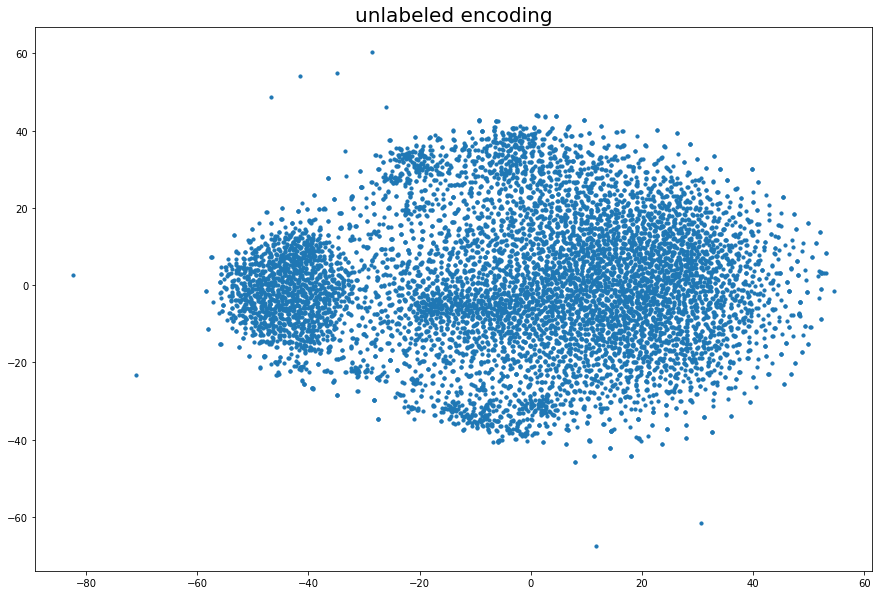

In [23]:
plot_tsne_df(tsne_df)

In [24]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [25]:
######################

In [26]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [27]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [28]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,AAA,1.800000,71.077900,13.0,88.600000
1,LLL,3.800000,113.157600,22.0,166.700000
2,ALA,2.466667,85.104467,16.0,114.633333
3,LAA,2.466667,85.104467,16.0,114.633333
4,AAL,2.466667,85.104467,16.0,114.633333


In [29]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,AAA,1.800000,71.077900,13.0,88.600000,14.678963,-11.365921
1,LLL,3.800000,113.157600,22.0,166.700000,-22.787785,19.373266
2,ALA,2.466667,85.104467,16.0,114.633333,-0.986433,-38.405979
3,LAA,2.466667,85.104467,16.0,114.633333,-1.114567,33.399536
4,AAL,2.466667,85.104467,16.0,114.633333,6.011907,-13.274528


In [30]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

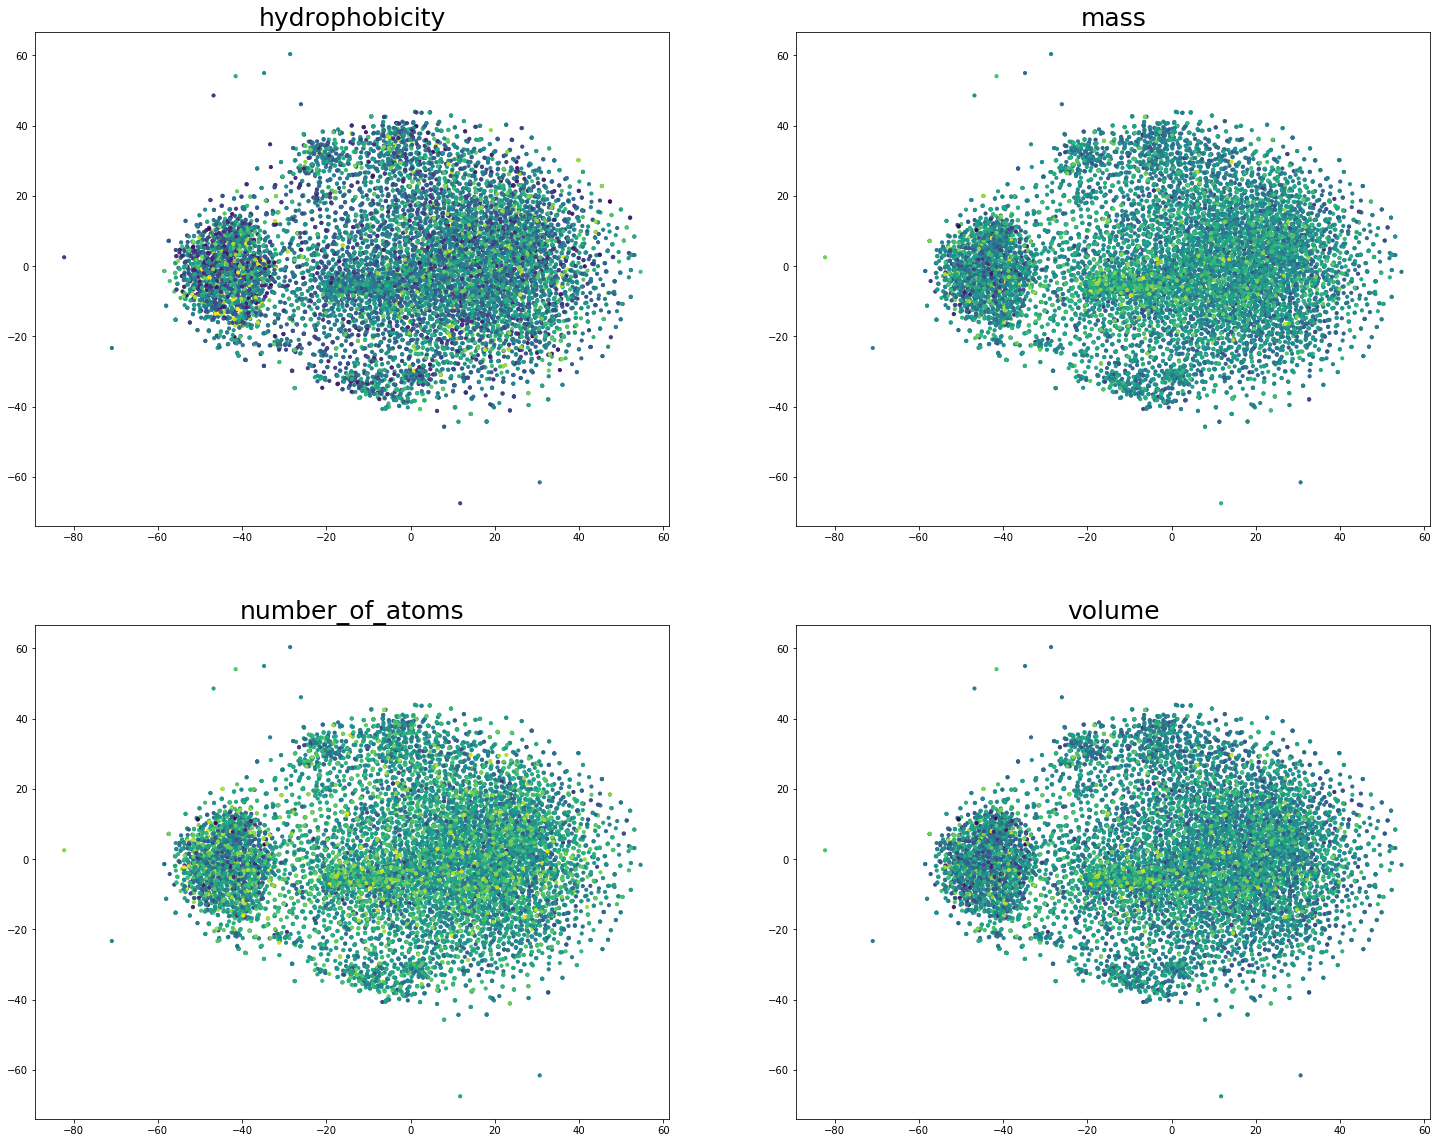

In [31]:
plot_embedding_properties(final_df)

In [32]:
######################

In [33]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

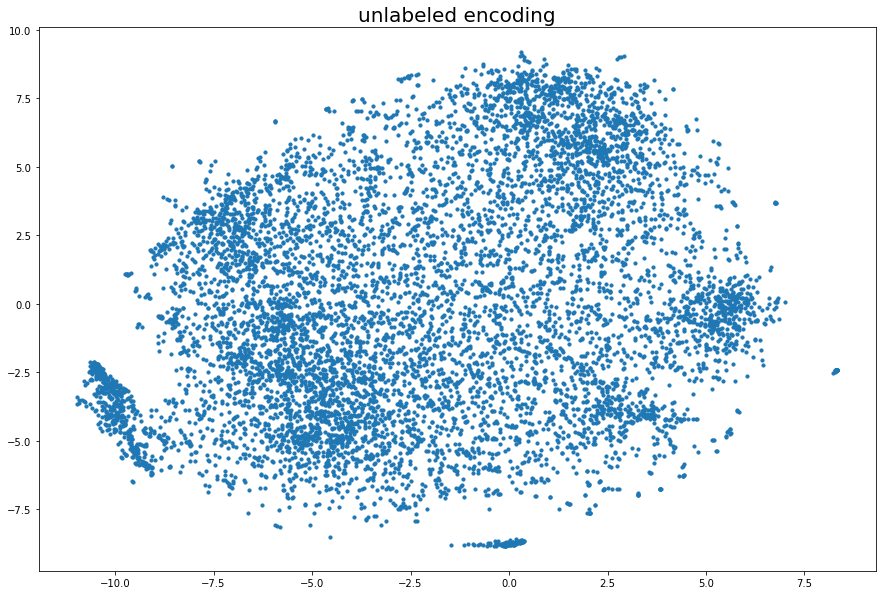

In [34]:
plot_tsne_df(gensim_tsne_df)

In [35]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

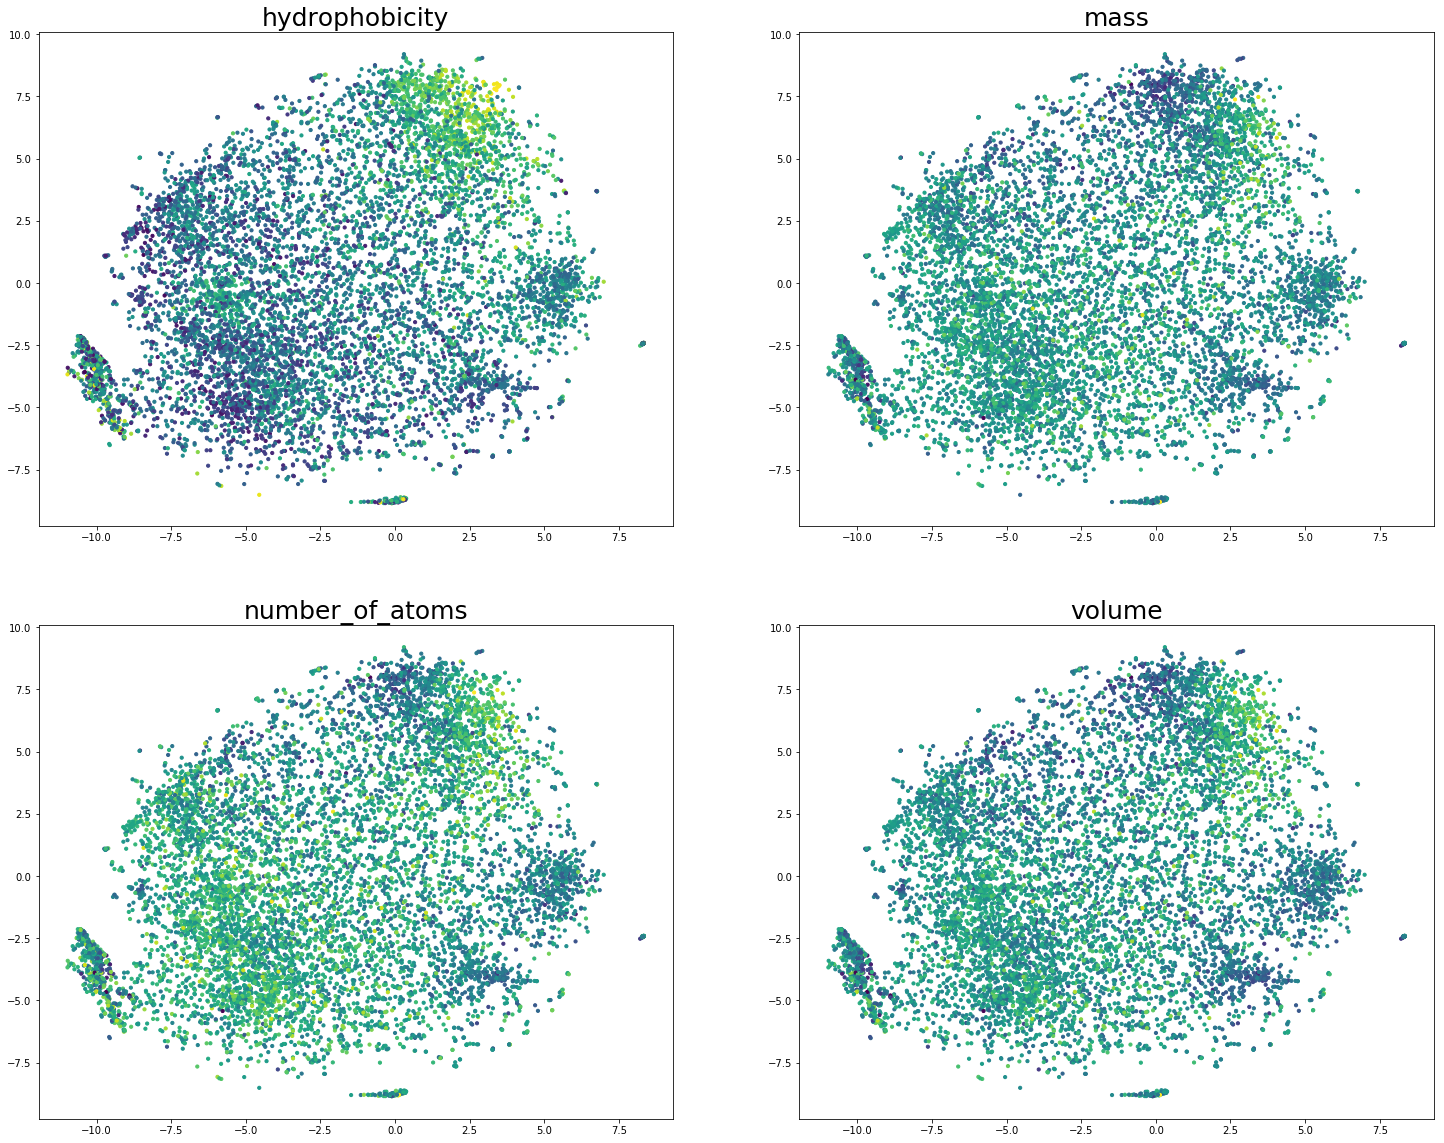

In [36]:
plot_embedding_properties(final_df_nice)

## Homework

Improve SkipGramModel to archive better embedding for amino acids codones. Visualize your space in the similar style as on the bottom example. You are only allowed to use vanilla tensorflow for this task.

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/